# Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

# Load Data

In [3]:
train = pd.read_csv('/content/twitter_training.csv', header = None)
val = pd.read_csv('/content/twitter_validation.csv', header = None)

In [4]:
train.columns = ['Tweet ID', 'entity', 'sentiment', 'Tweet content']
val.columns = ['Tweet ID', 'entity', 'sentiment', 'Tweet content']

In [5]:
len(train)

74682

In [6]:
len(val)

1000

In [7]:
train.sample(5)

,Tweet ID,entity,sentiment,Tweet content
67586,7175,johnson&johnson,Negative,We don't trust Johnson & Johnson tho. They lie...
60723,4804,GrandTheftAuto(GTA),Negative,Hahah some GTA love that
34436,6715,Fortnite,Negative,We have these bots that make the unplayed lmfa...
10581,13020,Xbox(Xseries),Positive,@GAMEWrexham @GAMEdigital just got the email.....
68318,3699,Cyberpunk2077,Negative,C. HP Lovecraft + Punk = Scary. caf.tv / divid...


In [8]:
val.sample(5)

,Tweet ID,entity,sentiment,Tweet content
305,13195,Xbox(Xseries),Positive,Great starting price.
838,9788,PlayStation5(PS5),Positive,Very much looking forward to getting new info ...
705,5025,GrandTheftAuto(GTA),Positive,The khanjali is the best tank in GTA online pi...
535,5311,Hearthstone,Neutral,The next major #Hearthstone update pays tribut...
475,11550,TomClancysRainbowSix,Negative,@Rainbow6Game Hey so i was playing ranked when...


In [9]:
train.isnull().sum()

Tweet ID           0
entity             0
sentiment          0
Tweet content    686
dtype: int64

In [10]:
train.duplicated().sum()

2700

In [11]:
train.drop_duplicates(inplace=True)

In [12]:
train.dropna(inplace = True)

In [13]:
train.reset_index(inplace = True)

In [14]:
val.isnull().sum()

Tweet ID         0
entity           0
sentiment        0
Tweet content    0
dtype: int64

In [ ]:
train['sentiment'].value_counts()

Negative      21698
Positive      19713
Neutral       17708
Irrelevant    12537
Name: sentiment, dtype: int64

([<matplotlib.patches.Wedge at 0x76ab315800a0>,
 [Text(0.638688594491415, 0.8955874492569562, 'Negative'),
  Text(-1.023669749440668, 0.40261674590121105, 'Positive'),
  Text(-0.33019873582158754, -1.0492706013521134, 'Neutral'),
  Text(0.9379747802153144, -0.5746331975095355, 'Irrelevant')],
 [Text(0.3483755969953173, 0.4885022450492488, '30.3%'),
  Text(-0.5583653178767278, 0.2196091341279333, '27.5%'),
  Text(-0.18010840135722955, -0.5723294189193345, '24.7%'),
  Text(0.5116226073901714, -0.31343628955065567, '17.5%')])

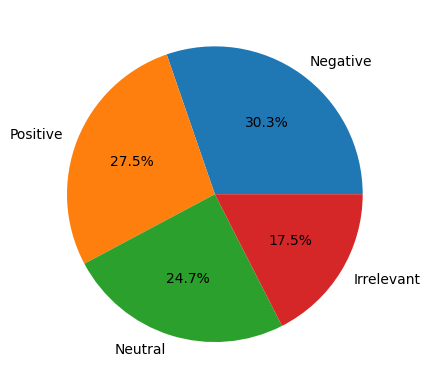

In [ ]:
plt.pie(train['sentiment'].value_counts(), labels = ['Negative', 'Positive', 'Neutral', 'Irrelevant'], autopct='%1.1f%%')

In [ ]:
df = train.groupby(['entity', 'sentiment']).count()

In [ ]:
df.reset_index(inplace = True)

In [ ]:
df

,entity,sentiment,index,Tweet ID,Tweet content
0,Amazon,Irrelevant,185,185,185
1,Amazon,Negative,565,565,565
2,Amazon,Neutral,1197,1197,1197
3,Amazon,Positive,302,302,302
4,ApexLegends,Irrelevant,185,185,185
...,...,...,...,...,...
123,Xbox(Xseries),Positive,743,743,743
124,johnson&johnson,Irrelevant,192,192,192
125,johnson&johnson,Negative,809,809,809
126,johnson&johnson,Neutral,1004,1004,1004


Text(0.5, 1.0, 'Tweets sentiment per entity')

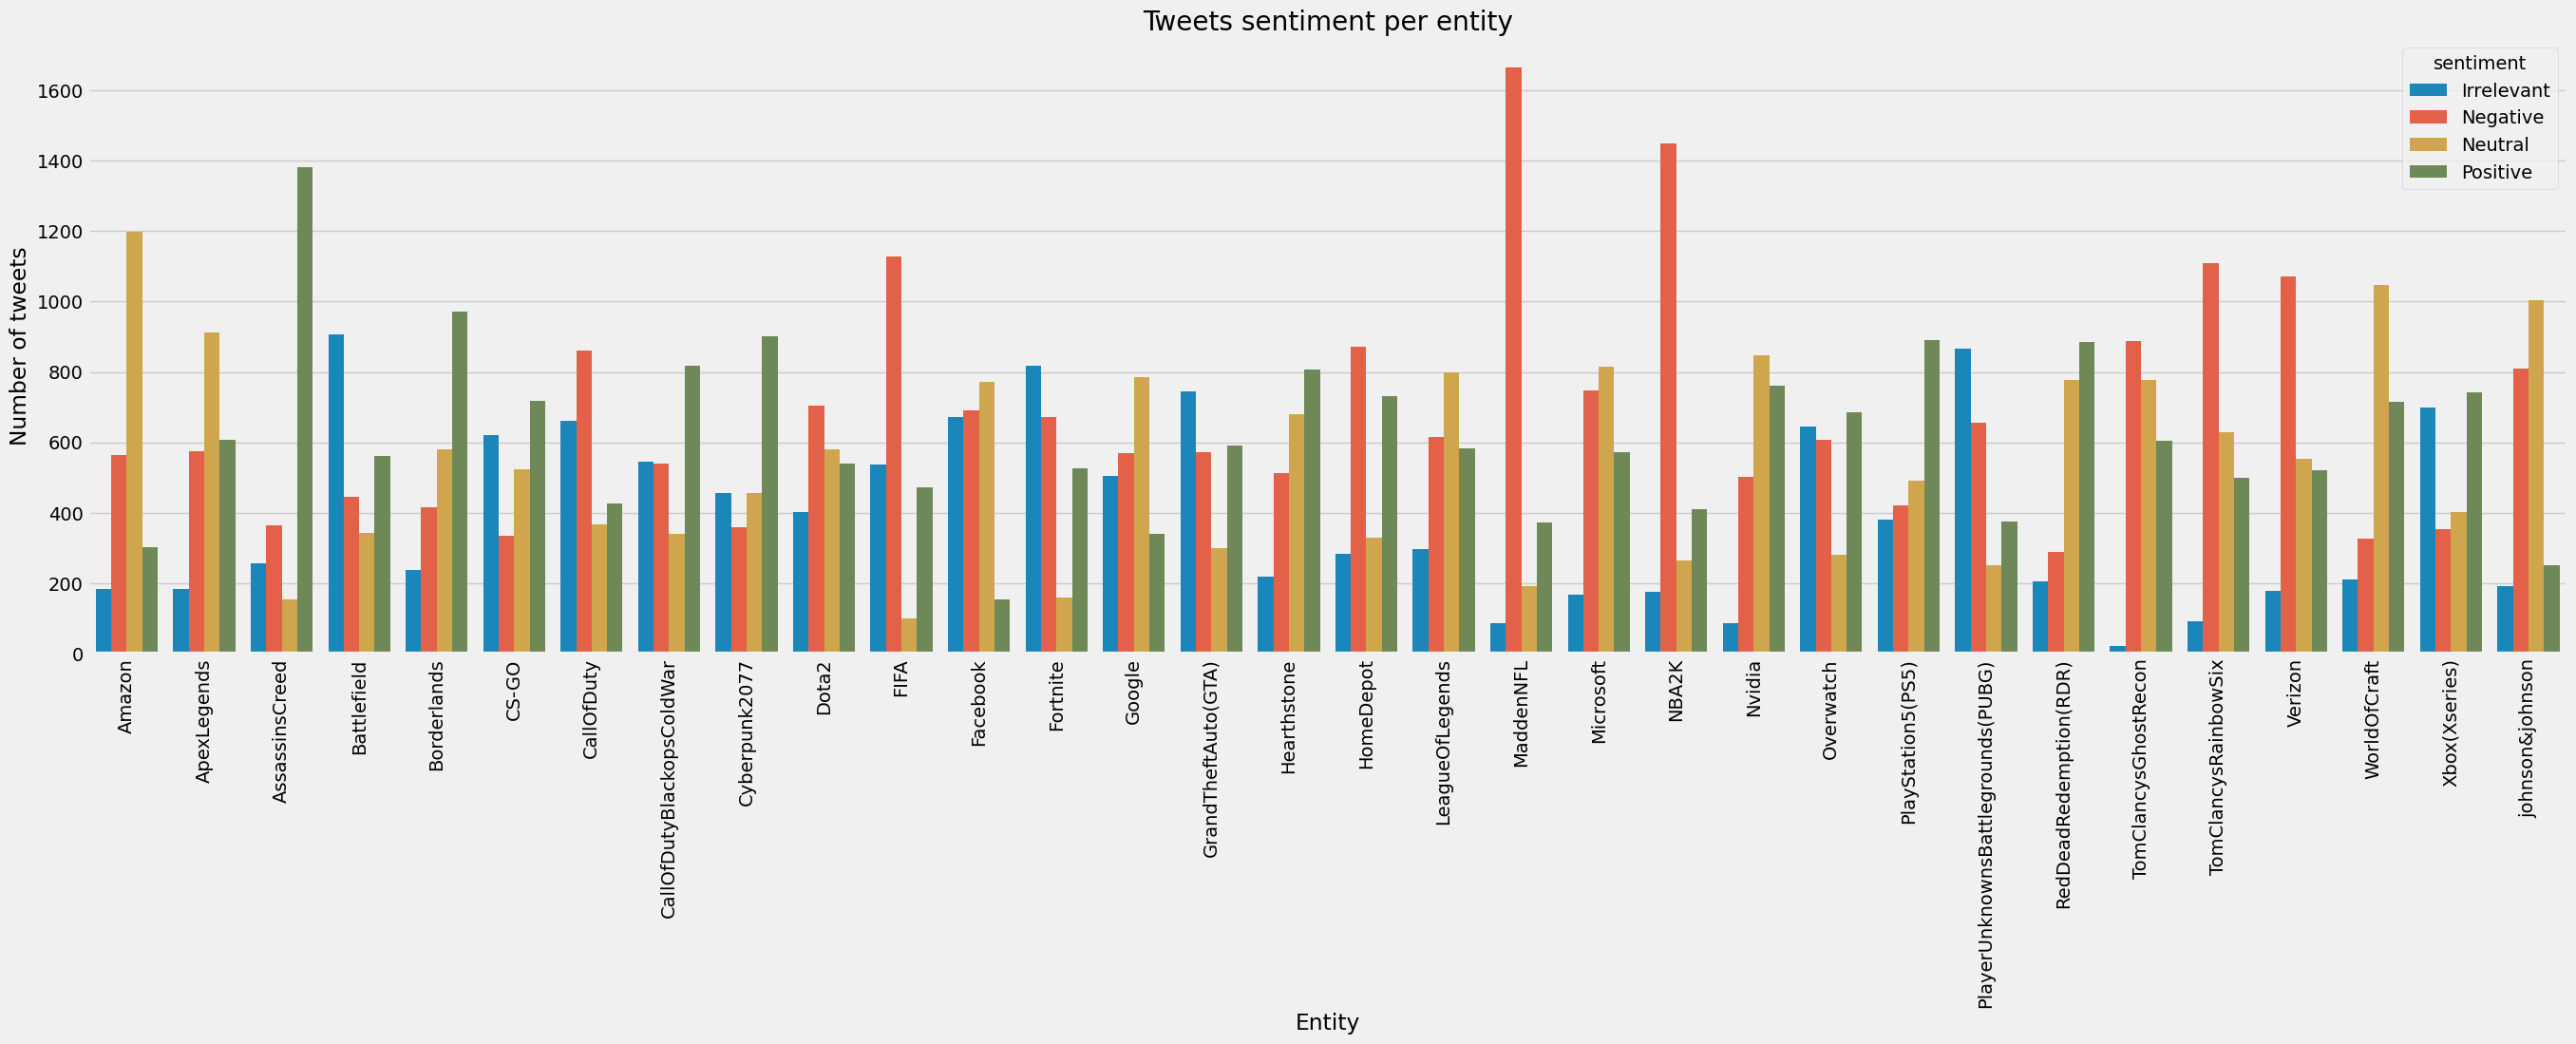

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(30, 8))
sns.barplot(df, x = "entity", y = "Tweet ID",hue = "sentiment")
plt.xticks(rotation = 90)
plt.xlabel("Entity")
plt.ylabel("Number of tweets")
plt.title("Tweets sentiment per entity")

In [ ]:
num_of_words = [len(tweet.split()) for tweet in train['Tweet content']]

In [ ]:
print(min(num_of_words))
print(max(num_of_words))
print(np.mean(num_of_words))

0
198
19.547965278553086


In [ ]:
mean_num = np.mean(num_of_words)

In [ ]:
num_of_words[:5]

[11, 12, 10, 10, 12]

<AxesSubplot: >

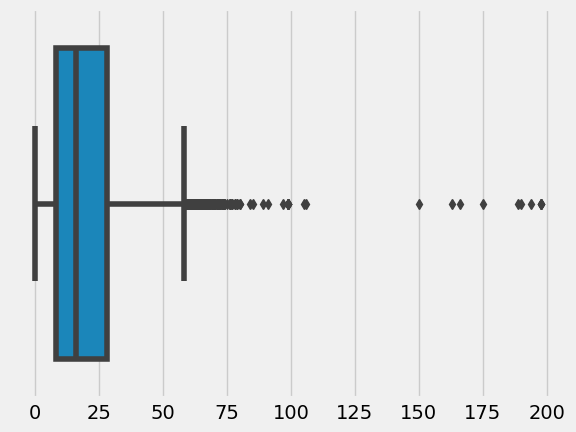

In [ ]:
sns.boxplot(x = num_of_words)

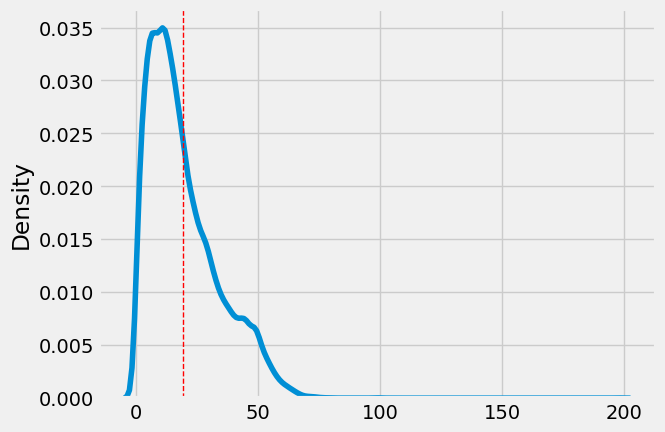

In [ ]:
sns.kdeplot(num_of_words)
plt.axvline(mean_num, color = 'r', linewidth = 1, linestyle = '--')

In [ ]:
# top words
import re
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

word_counts = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}

pattern = re.compile('[^\w ]')
for text, t in zip(train['Tweet content'], train['sentiment']):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)

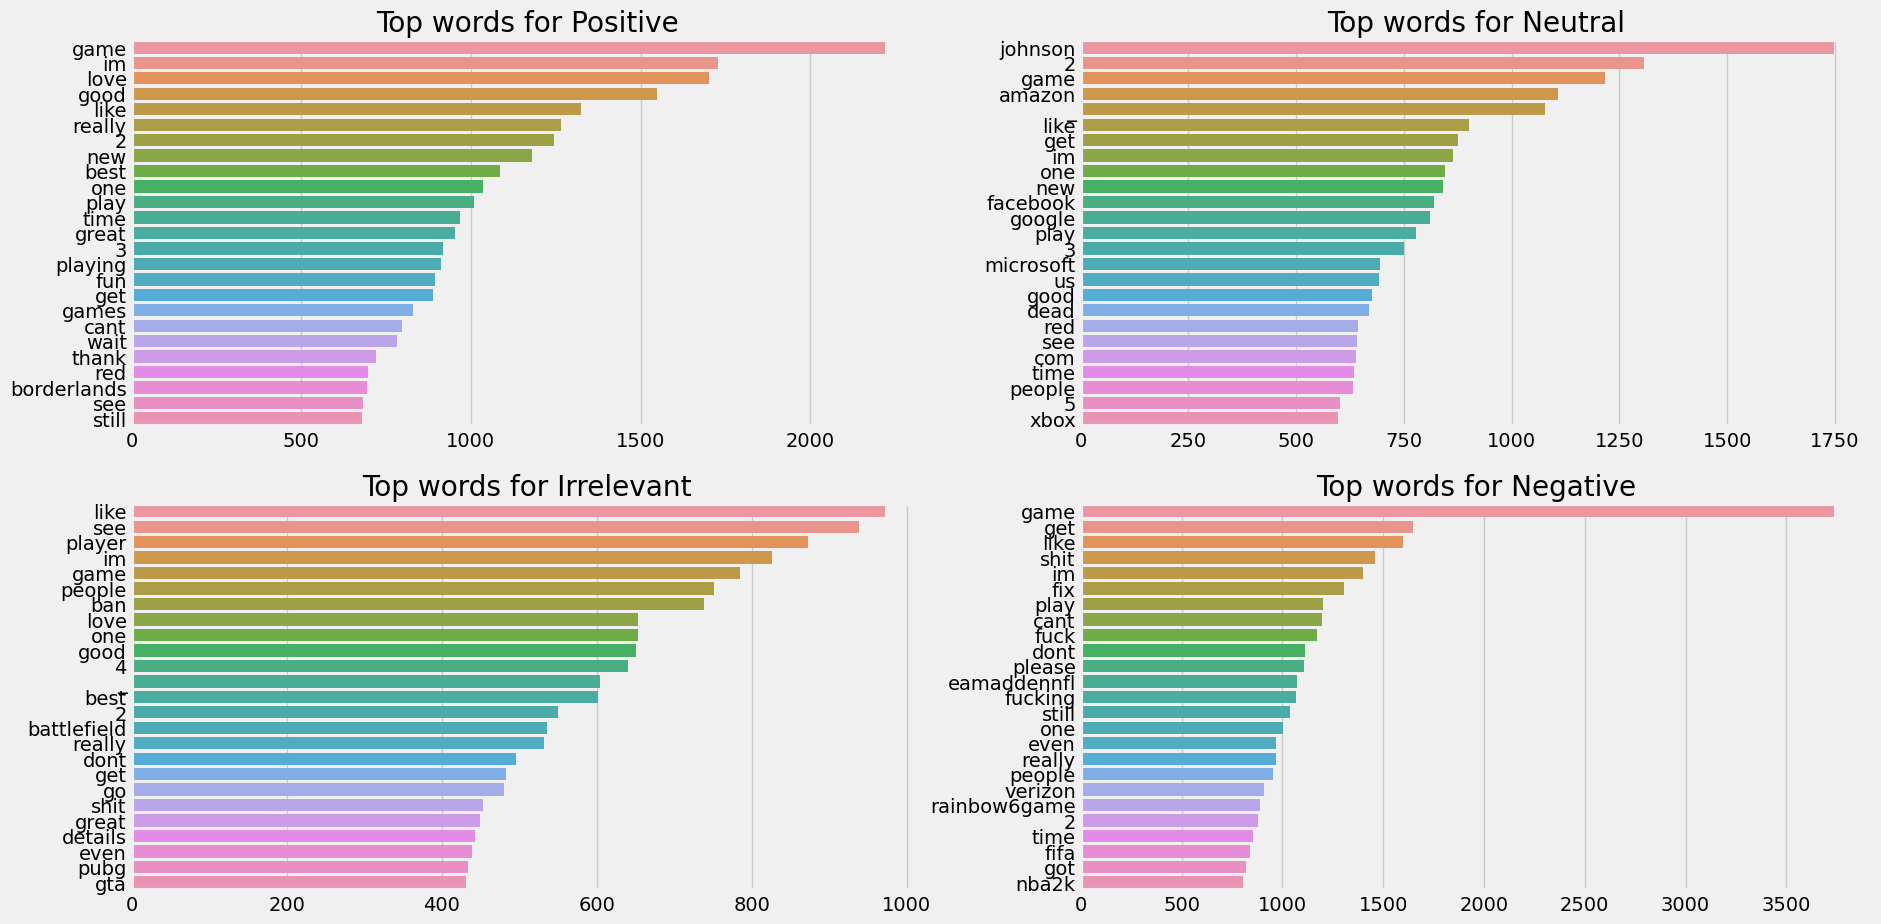

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

### Preprocessing

In [ ]:
X = train['Tweet content']

In [ ]:
X_val = val['Tweet content']

In [ ]:
X[1]

'i am coming to the borders and i will kill you all ,'

max Tweet_content len: 311


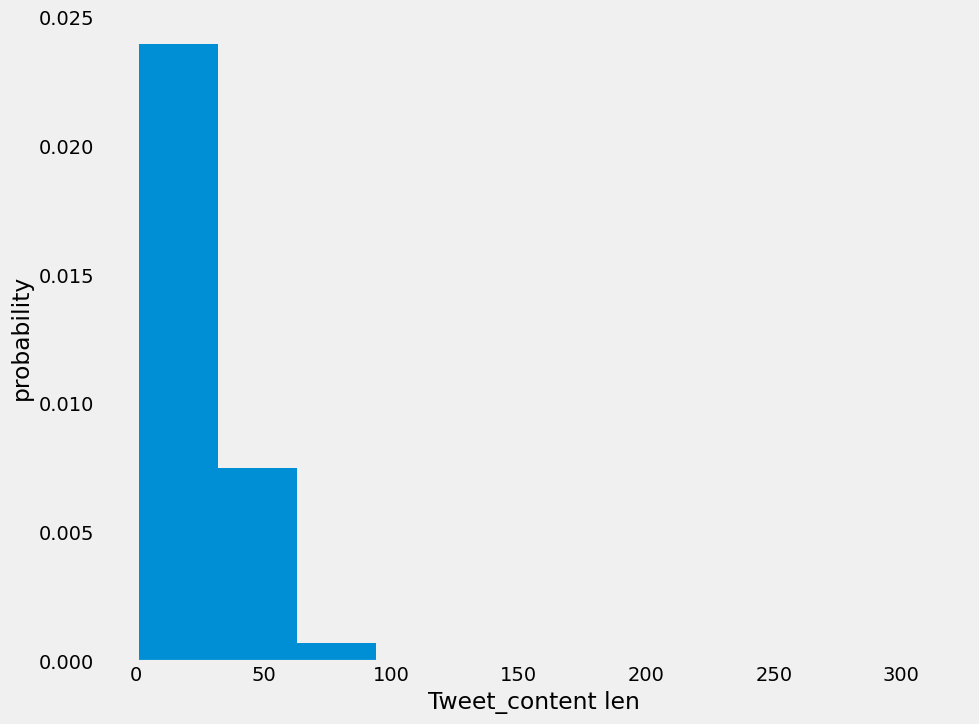

In [ ]:
Tweet_content_len = X.apply(lambda p: len(p.split(' ')))
max_Tweet_content_len = Tweet_content_len.max()
print('max Tweet_content len: {0}'.format(max_Tweet_content_len))
plt.figure(figsize = (10, 8))
plt.hist(Tweet_content_len, density = True)
plt.xlabel('Tweet_content len')
plt.ylabel('probability')
plt.grid()

In [ ]:
import re 
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
#1
def reviews(reviews):  
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]
    
    return reviews
#2
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words
#3
def get_lemmtized_text(corpus):
    lemmatizer = WordNetLemmatizer()

    return [' '.join([lemmatizer.stem(word) for word in review.split()]) for review in corpus]

In [ ]:
y =train['sentiment']

In [ ]:
y_val = val['sentiment']

In [ ]:

reviewtweet = reviews(X)

no_stop_words_tweet = remove_stop_words(reviewtweet)

lemmtized_reviews_tweet = get_lemmtized_text(no_stop_words_tweet)

In [ ]:
reviewtweet_val = reviews(X_val)

no_stop_words_tweet_val = remove_stop_words(reviewtweet_val)

lemmtized_reviews_tweet_val = get_limmtized_text(no_stop_words_tweet_val)

In [ ]:
lemmtized_reviews_tweet[1]

'come border kill ,'

### Encoding

In [ ]:
max_words = 8000


tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(lemmtized_reviews_tweet)
X = tokenizer.texts_to_sequences(lemmtized_reviews_tweet)
X = pad_sequences(X, maxlen = 300)

In [ ]:
max_words = 8000

tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(lemmtized_reviews_tweet_val)
X_val = tokenizer.texts_to_sequences(lemmtized_reviews_tweet_val)
X_val = pad_sequences(X_val, maxlen = 300)

In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

y = np.array(label_tokenizer.texts_to_sequences(y))

In [ ]:
label_tokenizer.fit_on_texts(y_val)
y_val = np.array(label_tokenizer.texts_to_sequences(y_val))

### Model

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = max_words, output_dim = 64, input_length = 300))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(64, dropout = 0.5, recurrent_dropout = 0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           512000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                        

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
monitor = EarlyStopping(monitor='val_loss', patience=5,verbose=1, mode='min', restore_best_weights=True)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test) , 
    epochs = 100,
    callbacks=[monitor],
    batch_size = 128)

Epoch 1/100
448/448 [==============================] - 564s 1s/step - loss: 1.2320 - accuracy: 0.4602 - val_loss: 0.9856 - val_accuracy: 0.6028
Epoch 2/100
448/448 [==============================] - 549s 1s/step - loss: 0.9533 - accuracy: 0.6244 - val_loss: 0.8211 - val_accuracy: 0.6834
Epoch 3/100
448/448 [==============================] - 538s 1s/step - loss: 0.8321 - accuracy: 0.6810 - val_loss: 0.7448 - val_accuracy: 0.7093
Epoch 4/100
448/448 [==============================] - 535s 1s/step - loss: 0.7664 - accuracy: 0.7083 - val_loss: 0.7151 - val_accuracy: 0.7229
Epoch 5/100
448/448 [==============================] - 541s 1s/step - loss: 0.7151 - accuracy: 0.7290 - val_loss: 0.6744 - val_accuracy: 0.7455
Epoch 6/100
448/448 [==============================] - 540s 1s/step - loss: 0.6763 - accuracy: 0.7452 - val_loss: 0.6592 - val_accuracy: 0.7480
Epoch 7/100
448/448 [==============================] - 535s 1s/step - loss: 0.6443 - accuracy: 0.7579 - val_loss: 0.6369 - val_accuracy:

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

# Pretrained Model (Roberta)

In [15]:
!pip install simpletransformers
from simpletransformers.classification import ClassificationModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 109.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [16]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

In [35]:
model = ClassificationModel(
    model_type = "roberta",
    model_name = model_name,
    num_labels=3,
    args={
        "use_multiprocessing": True,
        "use_multiprocessing_for_evaluation": True,
        'reprocess_input_data': True,
        'overwrite_output_dir': True,
        'num_train_epochs': 5,
        "optimizer" : "AdamW"
    },
    use_cuda=True,
)

In [36]:
train = train.rename(columns={"sentiment": "labels", "Tweet content": "text"})

In [37]:
train = train[train['labels'] != 'Irrelevant']

In [38]:
from sklearn.preprocessing import LabelEncoder

In [39]:
encoder = LabelEncoder()

In [40]:
train['labels'] = encoder.fit_transform(train['labels'])

In [41]:
train_df, val_df = train_test_split(train, test_size = 0.2)

In [42]:
model.train_model(
    train_df=train_df,
    eval_df = val_df,
    early_stopping_patience = 3, 
)

  0%|          | 0/47295 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/5912 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 5:   0%|          | 0/5912 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/5912 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/5912 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/5912 [00:00<?, ?it/s]

(29560, 0.2791616826300389)

In [43]:
from sklearn.metrics import f1_score

In [47]:
result, model_outputs, wrong_predictions = model.eval_model(val_df)
print(result)

  0%|          | 0/11824 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1478 [00:00<?, ?it/s]

{'mcc': 0.9143504684194195, 'eval_loss': 0.31443527815750066}
